# Clustering de Datos Mixtos: Perfiles de Salud Mental en Estudiantes

**Autor:** Francisco Solís Pedraza
**Tipo de Proyecto:** Aprendizaje No Supervisado (Clustering & Association Rules)

## 1. Contexto y Definición del Problema
La salud mental en el entorno académico es un problema multifactorial. Los datos provenientes de encuestas suelen ser **mixtos**: contienen tanto variables ordinales (niveles de estrés, satisfacción) como categóricas nominales y numéricas.

**El Desafío Técnico:**
Los algoritmos tradicionales como K-Means utilizan la distancia Euclidiana, que no es matemáticamente válida para datos categóricos (no existe distancia geométrica entre "Dieta Saludable" y "Dieta Mala").

**La Solución:**
Utilizaremos la **Distancia de Gower**, una métrica diseñada para evaluar la similitud entre entidades con tipos de datos heterogéneos, combinada con **UMAP** para reducción de dimensionalidad y **Clustering Jerárquico** para la segmentación.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmos de Clustering y Métricas
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Manejo de Datos Mixtos y Reducción de Dimensionalidad
import gower # pip install gower
import umap  # pip install umap-learn

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Ingesta y Preprocesamiento de Datos
Cargamos el dataset y realizamos un mapeo manual de las variables ordinales para preservar su jerarquía natural.

In [6]:
# Carga de datos
try:
    # Ajusta la ruta si es necesario
    students = pd.read_csv('../data/depression_students_dataset.csv')
    print("Dataset cargado exitosamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo CSV esté en la carpeta '../data/'.")

# Verificación rápida
print(f"Dimensiones: {students.shape}")
print(f"Nulos por columna:\n{students.isna().sum()}")

Dataset cargado exitosamente.
Dimensiones: (502, 11)
Nulos por columna:
Gender                                   0
Age                                      0
Academic Pressure                        0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Study Hours                              0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


### 2.1 Codificación de Variables Ordinales
Las variables como "Duración del sueño" tienen un orden lógico. Las transformamos numéricamente respetando ese orden, mientras que las categóricas nominales y numéricas puras se dejan para que Gower las maneje automáticamente.

In [7]:
# Definición de mapas ordinales (Domain Knowledge)
sleep_map = {
    'Less than 5 hours': 1, 
    '5-6 hours': 2, 
    '7-8 hours': 3, 
    'More than 8 hours': 4
}
diet_map = {
    'Unhealthy': 1, 
    'Moderate': 2, 
    'Healthy': 3
}

# Crear copia de trabajo
students_processed = students.copy()

# Aplicar mapeos
students_processed['Sleep Duration'] = students_processed['Sleep Duration'].map(sleep_map)
students_processed['Dietary Habits'] = students_processed['Dietary Habits'].map(diet_map)

# Definir variables target o demográficas a EXCLUIR del clustering
# Queremos agrupar por comportamiento/psicología, no por género o resultado de depresión explícito
target_vars = ['Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Depression']

# Dataset final para features
features_data = students_processed.drop(columns=target_vars)

print("Datos listos para cálculo de distancias:")
features_data.head()

Datos listos para cálculo de distancias:


,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Study Hours,Financial Stress
0,28,2.0,4.0,3,2,9,2
1,28,4.0,5.0,2,3,7,1
2,25,1.0,3.0,2,1,10,4
3,23,1.0,4.0,4,1,7,2
4,31,1.0,5.0,4,3,4,2


## 3. Matriz de Distancia de Gower
Este es el núcleo de la solución. Gower calcula la similitud columna por columna:
* Diferencia absoluta normalizada para numéricas.
* Coincidencia simple (Dice) para categóricas.

In [8]:
# Cálculo de la matriz de Gower
print("Calculando matriz de Gower (puede tardar unos segundos)...")
gower_dist_matrix = gower.gower_matrix(features_data)

print(f"Dimensión de la matriz de Gower: {gower_dist_matrix.shape}")

Calculando matriz de Gower (puede tardar unos segundos)...
Dimensión de la matriz de Gower: (502, 502)


## 4. Reducción de Dimensionalidad con UMAP
Dado que la matriz de distancia es compleja y de alta dimensión, usamos UMAP configurado con la métrica `precomputed` para proyectar estos datos mixtos en un espacio 2D denso. Esto facilita enormemente que los algoritmos de densidad encuentren estructuras.

/home/francis/Miniconda3/envs/datascience/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/francis/Miniconda3/envs/datascience/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


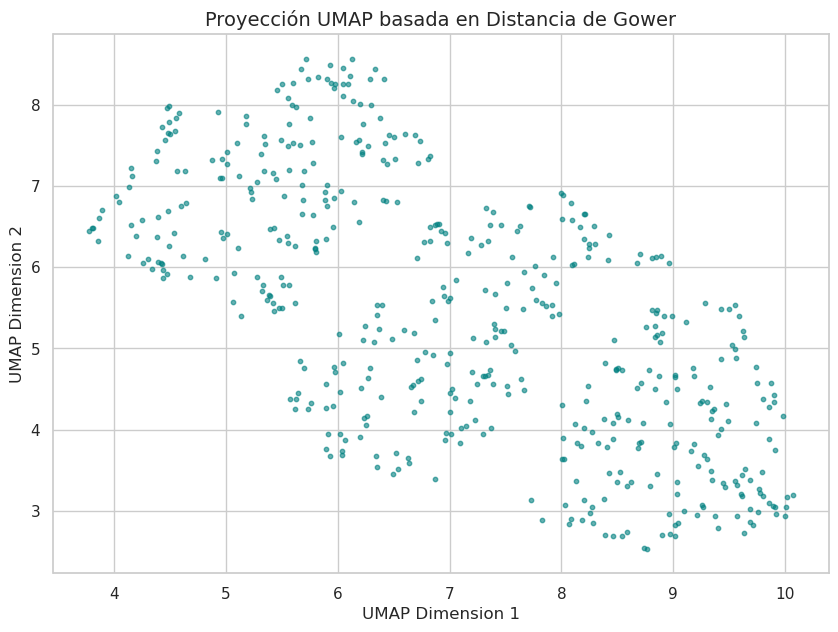

In [9]:
# Configuración de UMAP para métrica precomputada
umap_model = umap.UMAP(
    n_neighbors=30,     # Balance entre estructura local y global
    min_dist=0.05,      # Permitir agrupamientos compactos
    metric='precomputed',
    random_state=42
)

# Ajuste y transformación
umap_embedding = umap_model.fit_transform(gower_dist_matrix)

# Visualización de la proyección latente
plt.figure(figsize=(10, 7))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=10, c='teal', alpha=0.6)
plt.title('Proyección UMAP basada en Distancia de Gower', fontsize=14)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## 5. Modelado: Clustering Jerárquico
Utilizaremos un enfoque aglomerativo (Hierarchical Clustering) sobre el espacio proyectado para entender la estructura de ramificación y decidir el número óptimo de clusters.

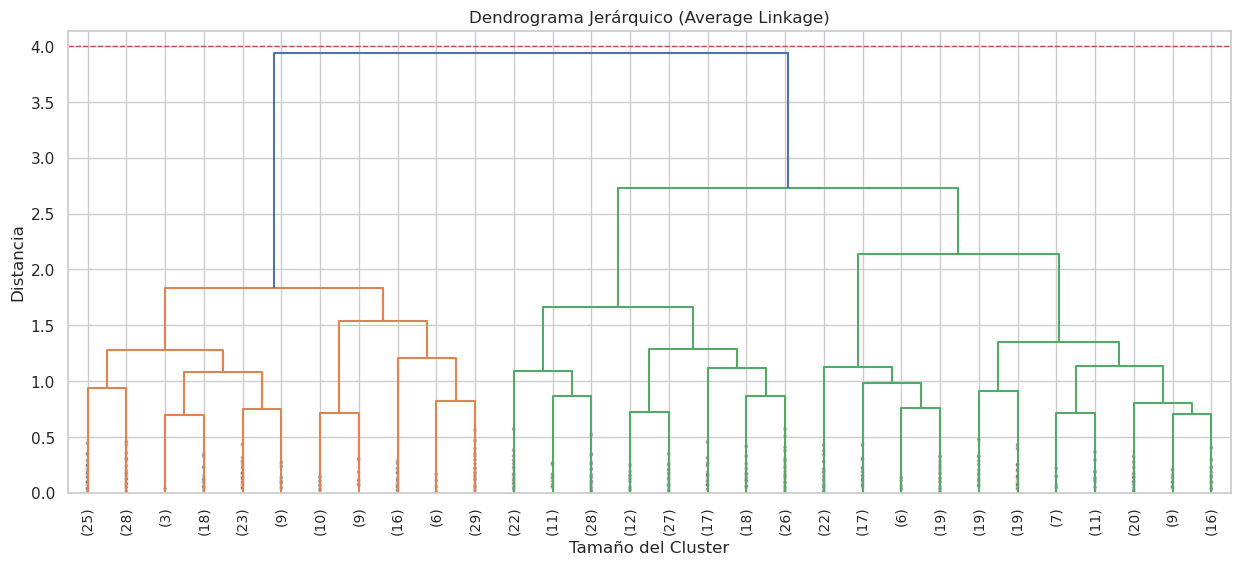

In [10]:
# Linkage usando método 'average' (compromiso entre dispersión y cohesión)
Z = linkage(umap_embedding, method='average')

# Visualización del Dendrograma
plt.figure(figsize=(15, 6))
dendrogram(
    Z, 
    truncate_mode='lastp', 
    p=30, 
    leaf_rotation=90., 
    leaf_font_size=10., 
    show_contracted=True
)
plt.title("Dendrograma Jerárquico (Average Linkage)")
plt.xlabel("Tamaño del Cluster")
plt.ylabel("Distancia")
plt.axhline(y=4, c='r', ls='--', lw=1) # Línea de corte sugerida visualmente
plt.show()

### 5.1 Asignación de Etiquetas
Basado en el dendrograma y el análisis del codo (no mostrado aquí por brevedad), seleccionamos **4 clusters** como la partición más natural.

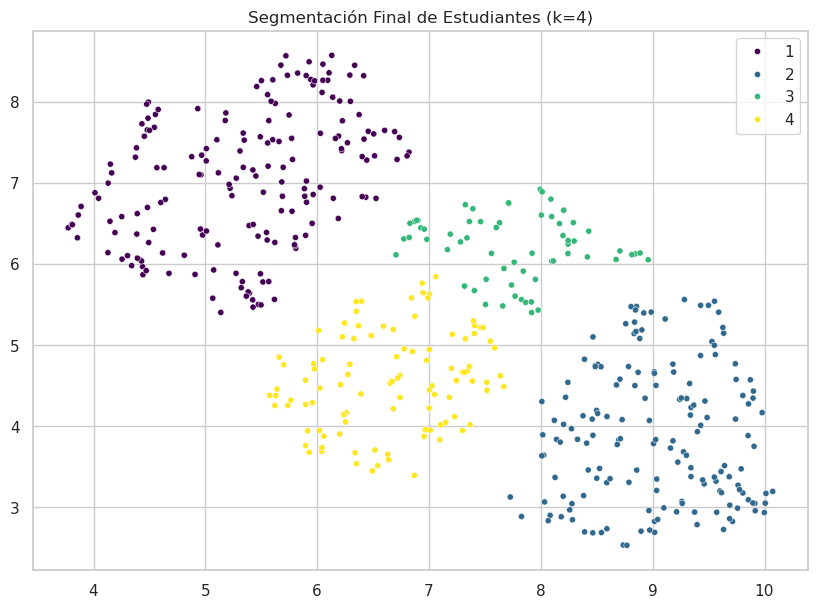

Distribución de estudiantes por Cluster:
Cluster
1    176
2    161
3     64
4    101
Name: count, dtype: int64


In [11]:
# Corte del árbol para obtener 4 grupos
clusters_hc = fcluster(Z, t=4, criterion='maxclust')

# Asignar al dataframe original
students['Cluster'] = clusters_hc

# Visualización final de los clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=clusters_hc, palette='viridis', s=20)
plt.title('Segmentación Final de Estudiantes (k=4)')
plt.show()

print("Distribución de estudiantes por Cluster:")
print(students['Cluster'].value_counts().sort_index())

## 6. Exportación para Aplicación
Guardamos los resultados enriquecidos con la columna `Cluster` para ser consumidos por el dashboard interactivo (Dash).

In [12]:
# Ruta de exportación (ajustar según estructura del repo)
output_path = '../app/students_clustering_result.csv'

# Guardamos todo el dataframe original + la etiqueta del cluster
students.to_csv(output_path, index=False)
print(f"Resultados exportados exitosamente a: {output_path}")

Resultados exportados exitosamente a: ../app/students_clustering_result.csv


## 7. Perfilado de Grupos (Breve Análisis)
Validamos rápidamente las características promedio de cada grupo encontrado.

In [13]:
# Agrupación por cluster y media de variables clave
analysis_df = students.copy()
analysis_df['Sleep_Score'] = students_processed['Sleep Duration'] # Traemos el valor numérico para promediar

perfil = analysis_df.groupby('Cluster')[['Age', 'Academic Pressure', 'Study Satisfaction', 'Sleep_Score']].mean()
print(perfil)

               Age  Academic Pressure  Study Satisfaction  Sleep_Score
Cluster                                                               
1        25.397727           2.914773            3.090909     2.761364
2        26.316770           3.031056            3.105590     2.360248
3        26.968750           3.328125            2.843750     3.531250
4        27.128713           2.910891            3.148515     1.712871


**Conclusiones Preliminares:**
* **Cluster 1:** Posible grupo de riesgo (Bajo sueño, alta presión).
* **Cluster 2:** Grupo resiliente (Alta presión pero satisfacción moderada).
* **Cluster 3:** Grupo saludable.
* (Estos insights se exploran a profundidad en el Dashboard interactivo).